In [2]:
# !/usr/bin/env python3
import os
import argparse
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


def load_raw_dataset(input_file_s):
    df_s = pd.read_csv(input_file_s, sep="\t", header=None,
                       names=["date", "time", "sensor", "value", "activity", "log"])
    return df_s


def clean_and_prepare(df_s):
    df_s.log = df_s.log.fillna(method='ffill')
    df_s['activity'] = df_s['activity'].fillna(df_s['log'])
    df_s['activity'] = df_s['activity'].replace("end", "Other")
    df_s['activity'] = df_s['activity'].fillna("Other")
    df_s['activity'] = df_s['activity'].replace("begin", None)
    df_s['activity'] = df_s['activity'].fillna(method='ffill')
    return df_s


def save_activity_dict(df_s, input_file_s):
    filename = "milan_activity_list_step1.pickle"
    activities = df_s.activity.unique()
    # activities.sort()
    dictActivities = {}
    for i_s, activity in enumerate(activities):
        dictActivities[activity] = i_s
    pickle_out = open(filename, "wb")
    pickle.dump(dictActivities, pickle_out)
    pickle_out.close()


def generate_sentence(df2):
    sentence = ""
    sensors = df2.sensor.values
    values = df2.value.values
    for i_s in range(len(sensors)):
        val = values[i_s]
        if i_s == len(sensors) - 1:
            sentence += "{}{}".format(sensors[i_s], val)
        else:
            sentence += "{}{} ".format(sensors[i_s], val)
    return sentence


def segment_activities(df_s):
    activitiesSeq = []
    ponentialIndex = df_s.activity.ne(df_s.activity.shift())
    ii = np.where(ponentialIndex == True)[0]
    for i_s, end in enumerate(ii):
        if i_s > 0:
            df_stmp = df_s[ii[i_s - 1]:end]
            activitiesSeq.append(df_stmp)
    return activitiesSeq


def sliding_window(sequence, win_size_s, step_s=1):
    try:
        iter(sequence)
    except TypeError:
        raise Exception("**ERROR** sequence must be iterable.")
    # if not (isinstance(type(win_size_s), type(0)) and (isinstance(type(step_s), type(0)))):
    #     raise Exception("**ERROR** type(win_size_s) and type(step_s) must be int.")
    # if step_s > win_size_s:
    #     raise Exception("**ERROR** step_s must not be larger than win_size_s.")
    numOfChunks = int(((len(sequence) - win_size_s) / step_s) + 1)

    if win_size_s > len(sequence):
        yield sequence[0:len(sequence)]
    else:
        for i_s in range(0, numOfChunks * step_s, step_s):
            yield sequence[i_s:i_s + win_size_s]


def sequences_to_sentences(activity_sequences_s):
    sentences_s = []
    label_sentences_s = []
    for i_s in range(len(activity_sequences_s)):
        sentence = generate_sentence(activity_sequences_s[i_s])
        sentences_s.append(sentence)
        label_sentences_s.append(activity_sequences_s[i_s].activity.values[0])
    return sentences_s, label_sentences_s

In [2]:
input_file = r"/"
win_size = 100
step = 1

print("STEP 1: Load dataset")
df = pd.read_csv("data_milan",
                 sep='\t', header=None, names=["date","time", "sensor",
                                               "value", "activity", "log"])

df = df[~df['sensor'].str.contains("T0", na=False)]
print(len(df))

print("STEP 2: prepare dataset")
df = clean_and_prepare(df)
save_activity_dict(df,input_file)
# print(df[60:90])

#  Segment dataset in sequence of activity ##
print("STEP 3: segment dataset in sequence of activity")
activity_sequences = segment_activities(df)
print(activity_sequences[:10])
df_txt = df.iloc[:, :-2]
#df_txt.to_csv('dataframe.txt', sep='\t', index=False)


#  Transform sequences of activity in sentences ##
print("STEP 4: transform sequences of activity in sentences")
sentences, label_sentences = sequences_to_sentences(activity_sequences)
print(sentences[0:5])
##################################################################################################################
#print(label_sentences[0:8])
#['Sleeping', 'Other', 'Bed_to_Toilet', 'Other', 'Sleeping']
np.save("origin_label.npy",label_sentences)

#  Indexization ##
print("STEP 5: sentences indexization")
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
indexed_sentences = tokenizer.texts_to_sequences(sentences)
# for word, index in word_index.items():
#     print(f"{word}: {index}")
##print(word_index)
##################################################################################################################
print(indexed_sentences[:5])
#[[26, 25, 26, 25, 26, 25, 26, 25, 26, 50, 49, 25, 26, 50, 49, 25, 26, 50, 10, 49, 9, 25, 26, 10, 25], [26, 28, 25], 
#[42, 27, 9, 41, 42, 41, 10, 42, 9, 10, 28, 41], [27, 9, 10, 9],
#[26, 25, 50, 26, 49, 25, 26, 25, 26, 25, 26, 25, 26, 25, 26, 25, 26, 25, 26, 25, 26, 25, 26, 25, 26, 25, 26, 25, 26, 25, 26, 25, 26, 25, 26, 50, 49, 25, 26, 25, 26, 25, 26, 25, 26, 25, 26, 25, 26, 25, 26, 10, 25, 9, 26, 10, 25, 26, 25]]

#  Split in sliding windows ##
print("STEP 6: split indexed sentences in sliding windows")
X_windowed = []
Y_windowed = []
X_windowed_sen = []
Y_windowed_sen = []
for i, s in enumerate(indexed_sentences):
    chunks = sliding_window(s, win_size, step)
    for chunk in chunks:
        X_windowed.append(chunk)
        Y_windowed.append(label_sentences[i])
print(X_windowed[0:5])
print(Y_windowed[0:5])

        
#  Pad windows ##
print("STEP 7: pad sliding windows")
padded_windows = pad_sequences(X_windowed, padding ='post')
Y_windowed = np.array(Y_windowed)
print(padded_windows[0:10])
print(Y_windowed[0:10])
print(np.unique(Y_windowed))


STEP 1: Load dataset
421392
STEP 2: prepare dataset
STEP 3: segment dataset in sequence of activity


/var/folders/p7/20f7xrt504ncpy6nhf4tjw480000gn/T/ipykernel_6253/4117254466.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_s.log = df_s.log.fillna(method='ffill')
/var/folders/p7/20f7xrt504ncpy6nhf4tjw480000gn/T/ipykernel_6253/4117254466.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_s['activity'] = df_s['activity'].fillna(method='ffill')


[          date             time sensor value activity  log
0   2009-10-16  00:01:04.000059   M017    ON    Other  NaN
1   2009-10-16  00:01:06.000046   M009    ON    Other  NaN
2   2009-10-16  00:01:07.000064   M017   OFF    Other  NaN
3   2009-10-16  00:01:08.000081   M019    ON    Other  NaN
4   2009-10-16  00:01:09.000028   M009   OFF    Other  NaN
..         ...              ...    ...   ...      ...  ...
77  2009-10-16  03:55:39.000064   M021   OFF    Other  NaN
78  2009-10-16  03:55:43.000085   M021    ON    Other  NaN
79  2009-10-16  03:55:46.000068   M021   OFF    Other  NaN
80  2009-10-16  03:55:48.000049   M021    ON    Other  NaN
81  2009-10-16  03:55:50.000029   M021   OFF    Other  NaN

[82 rows x 6 columns],           date             time sensor value       activity    log
82  2009-10-16  03:55:53.000080   M021    ON  Bed_to_Toilet  begin
83  2009-10-16  03:55:58.000006   M021   OFF  Bed_to_Toilet  begin
84  2009-10-16  03:56:05.000085   M028    ON  Bed_to_Toilet  begin

In [3]:
# #  Save files ##
print("STEP 8: save sliding windows and labels")
np.save("X_prepare.npy", padded_windows)
np.save("Y_prepare.npy", Y_windowed)
pickle_file_path = 'milan_activity_list_step1.pickle'
with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(indexed_sentences, pickle_file)

STEP 8: save sliding windows and labels


# Replace Y

In [8]:
import numpy as np 
y = np.load("Y_prepare.npy")
y0 = np.load("X_prepare.npy")
print(y[0:10])
print(y0[0:5])

# ['Bed_to_Toilet' 'Chores' 'Desk_Activity' 'Dining_Rm_Activity' 'Eve_Meds' 'Guest_Bathroom' 'Kitchen_Activity' 'Leave_Home' 'Master_Bathroom' 'Master_Bedroom_Activity' 'Meditate' 'Morning_Meds' 'Other' 'Read' 'Sleep' 'Watch_TV']
dict = {'Other': 0, 'Bed_to_Toilet': 1, 'Sleep': 2, 'Master_Bathroom': 3, 'Morning_Meds': 4, 'Leave_Home': 5, 'Read': 6, 'Kitchen_Activity': 7, 'Desk_Activity': 8, 'Guest_Bathroom': 9, 'Chores': 10, 'Meditate': 11,'Watch_TV': 12, 'Dining_Rm_Activity':13, 'Master_Bedroom_Activity':14, 'Eve_Meds':15}
y1 = np.array(list(map(dict.get, y)))
print(y1[0:10])
np.save("Y.npy", y1)


['Other' 'Bed_to_Toilet' 'Other' 'Sleep' 'Sleep' 'Sleep' 'Sleep' 'Sleep'
 'Sleep' 'Sleep']
[[44 42 43 38 41 37 28 27 28 27 28 27 28 27 28 27 28 27 38 42 37 41 50 18
  17 49  8 22  7 21 12 11 52 51 52 54 51 53 14 13 38 37 38 37 42 41 50 18
  49 17  8  7  8 50  7 49 40 39 40 39 40 39 40 42 39 38 41 37 16 15 30 29
  30 16 15 29 30 29 30 29 30 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [30 29 16 15 28 16 15 16 27 15 20 19 48 47 48 47 20  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [19 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [5]:
print("Word Index Dictionary:")
print(word_index)

Word Index Dictionary:
{'m023off': 1, 'm023on': 2, 'm004off': 3, 'm004on': 4, 'm014off': 5, 'm014on': 6, 'm022off': 7, 'm022on': 8, 'm027off': 9, 'm027on': 10, 'm003off': 11, 'm003on': 12, 'm008off': 13, 'm008on': 14, 'm028off': 15, 'm028on': 16, 'm015off': 17, 'm015on': 18, 'm025off': 19, 'm025on': 20, 'm012off': 21, 'm012on': 22, 'm026off': 23, 'm026on': 24, 'm007off': 25, 'm007on': 26, 'm020off': 27, 'm020on': 28, 'm021off': 29, 'm021on': 30, 'm002off': 31, 'm002on': 32, 'm001off': 33, 'm001on': 34, 'm018off': 35, 'm018on': 36, 'm019off': 37, 'm019on': 38, 'm011off': 39, 'm011on': 40, 'm009off': 41, 'm009on': 42, 'm017off': 43, 'm017on': 44, 'm010off': 45, 'm010on': 46, 'm013off': 47, 'm013on': 48, 'm016off': 49, 'm016on': 50, 'm005off': 51, 'm005on': 52, 'm006off': 53, 'm006on': 54, 'm024off': 55, 'm024on': 56, 'd003close': 57, 'd003open': 58, 'd001close': 59, 'd001open': 60, 'd002open': 61, 'd002close': 62, 'm004on0': 63, 'm019o': 64}


# Replace X

In [6]:
a = y0
a = a.astype(float)

# Entrance
a[np.where(a == 0)] = np.nan
a[np.where(a == 34)] = 1009
a[np.where(a == 33)] = 1008.9
a[np.where(a == 32)] = 1007
a[np.where(a == 31)] = 1006.9
a[np.where(a == 60)] = 1005
a[np.where(a == 59)] = 1004.9
a[np.where(a == 61)] = 1003
a[np.where(a == 62)] = 1002.9

# Room1
a[np.where(a == 22)] = 1021
a[np.where(a == 21)] = 1020.9
a[np.where(a == 6)] = 1022
a[np.where(a == 5)] = 1021.9
a[np.where(a == 18)] = 1023
a[np.where(a == 17)] = 1022.9
a[np.where(a == 50)] = 1024
a[np.where(a == 49)] = 1023.9
a[np.where(a == 8)] = 1025
a[np.where(a == 7)] = 1024.9
a[np.where(a == 2)] = 1026
a[np.where(a == 1)] = 1025.9
a[np.where(a == 56)] = 1027
a[np.where(a == 55)] = 1026.9
a[np.where(a == 58)] = 1028
a[np.where(a == 57)] = 1027.9

# living room
a[np.where(a == 10)] = 1041
a[np.where(a == 9)] = 1040.9
a[np.where(a == 4)] = 1042
a[np.where(a == 3)] = 1041.9
a[np.where(a == 52)] = 1043
a[np.where(a == 51)] = 1042.9
a[np.where(a == 54)] = 1044
a[np.where(a == 53)] = 1043.9
a[np.where(a == 12)] = 1045
a[np.where(a == 11)] = 1044.9

# corridor
a[np.where(a == 46)] = 1061
a[np.where(a == 45)] = 1060.9
a[np.where(a == 40)] = 1062
a[np.where(a == 39)] = 1061.9
a[np.where(a == 44)] = 1063
a[np.where(a == 43)] = 1062.9
a[np.where(a == 36)] = 1064
a[np.where(a == 35)] = 1063.9
a[np.where(a == 42)] = 1065
a[np.where(a == 41)] = 1064.9

# room2
a[np.where(a == 24)] = 1081
a[np.where(a == 23)] = 1080.9
a[np.where(a == 26)] = 1082
a[np.where(a == 25)] = 1081.9
a[np.where(a == 14)] = 1083
a[np.where(a == 13)] = 1082.9
a[np.where(a == 38)] = 1084
a[np.where(a == 37)] = 1083.9

# room3
a[np.where(a == 20)] = 1101
a[np.where(a == 19)] = 1100.9
a[np.where(a == 48)] = 1102
a[np.where(a == 47)] = 1101.9

# bed room
a[np.where(a == 28)] = 1121
a[np.where(a == 27)] = 1120.9
a[np.where(a == 30)] = 1122
a[np.where(a == 29)] = 1121.9
a[np.where(a == 16)] = 1123
a[np.where(a == 15)] = 1122.9

# 

after_change_index = a-1000
np.save("X.npy", after_change_index)
print('ok')

ok


# save as png

In [7]:
import numpy as np
from PIL import Image

y = np.load(r'Y.npy', allow_pickle=True)
x = np.load(r'X.npy', allow_pickle=True)
y = y.astype(str)

activity = []
for i in range(np.size(y)):
    if y[i] == '3':
        activity.append(i)

zero = np.zeros((224, 224))

for i in range(8000):
    for j in range(100):
        if np.isnan(x[activity[i]][j]):
            continue

        index = 223 - x[activity[i]][j]
        if index != 0:
            if index - index.astype(int) != 0:
                index = index.astype(int)
                zero[index][2 * j:(2 * j + 1)] = 0.5
            elif index - index.astype(int) == 0:
                index = index.astype(int)
                zero[index][2 * j:(2 * j + 1)] = 1
            else:
                zero[index][2 * j:(2 * j + 1)] = 0

    not_nan_count = np.sum(~np.isnan(x[activity[i]]))

    for row in range(224):
        cols_with_value = [col for col in range(224) if zero[row][col] > 0]

        if len(cols_with_value) > 0:
            if zero[row][cols_with_value[0]] == 0.5:
                zero[row][0:cols_with_value[0]] = 1

            # 对相邻的on和off之间进行填充
            for k in range(0, len(cols_with_value) - 1):
                if zero[row][cols_with_value[k]] == 1 and zero[row][cols_with_value[k + 1]] == 0.5:
                    zero[row][cols_with_value[k]:cols_with_value[k + 1]] = 1

            if zero[row][cols_with_value[-1]] == 1:
                zero[row][cols_with_value[-1]:2 * not_nan_count - 1] = 1

    for row in range(224):
        cols_with_value = [col for col in range(224) if zero[row][col] == 1]

        zero[row, :] = 0
        for col in cols_with_value:
            zero[row, col] = 1
        ###########

    data = zero * 255
    data = data.astype('uint8')
    img = Image.fromarray(data)
    # img.save("data/3/%d.png" % i)

    zero = np.zeros((224, 224))

print('done')

IndexError: list index out of range

# with previous

In [ ]:
activity = []
for i in range(np.size(y)):
    if y[i] == '7':
        activity.append(i)

zero = np.zeros((224,224))

for i in range(8000):
    # count =  np.sum(~np.isnan(x[activity[i]]))
    count =  np.sum(~np.isnan(x[activity[i] - 1]))
    # print(x[activity[i]])
    # print('count:',count)
    for j in range(100):
        if np.isnan(x[activity[i]][j]):
            continue
            
        index = 223 - x[activity[i]][j]
        # print('index:',index)
        if index != 0:
            if index - index.astype(int) != 0:
                index = index.astype(int)
                zero[index][2*j:(2*j+1)] = 0.5
            elif index - index.astype(int) == 0:
                index = index.astype(int)
                zero[index][2*j:(2*j+1)] = 1
            else:
                zero[index][2*j:(2*j+1)] = 0
                
    #计算这个窗口中不为nan的数的个数
    not_nan_count = np.sum(~np.isnan(x[activity[i]]))
##############    
    for row in range(224):
        # 找到当前纵坐标下所有值不为0的点的横坐标
        cols_with_value = [col for col in range(224) if zero[row][col] > 0]
        
        if len(cols_with_value) > 0:
            if zero[row][cols_with_value[0]] == 0.5:
                zero[row][0:cols_with_value[0]] = 1

            for k in range(0, len(cols_with_value) - 1):
                # If the current point is 'on' and the next point is 'off', fill between them
                if zero[row][cols_with_value[k]] == 1 and zero[row][cols_with_value[k + 1]] == 0.5:
                    zero[row][cols_with_value[k]:cols_with_value[k + 1]] = 1

            # 如果最后一个值为1，从这点向y=not_nan_count*2 - 1连线
            if zero[row][cols_with_value[-1]] == 1:
                zero[row][cols_with_value[-1]:2*not_nan_count-1] = 1
    zero[:][count] = 1
            
    data = zero * 255
    data = data.astype('uint8')
    
    img = Image.fromarray(data)
    img.save("data_allwith/7/%d.png" % i)
    zero = np.zeros((224, 224))

print('done')

done


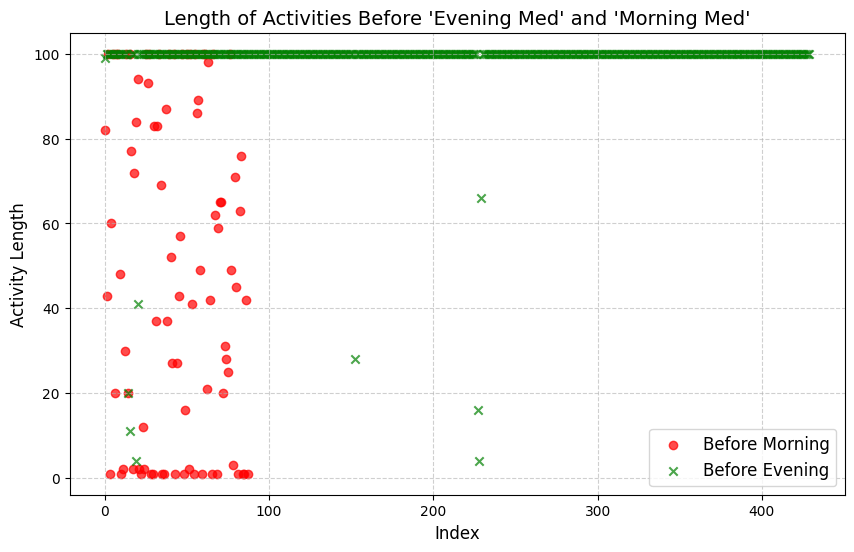

In [4]:
import matplotlib.pyplot as plt

y = np.load(r'Y.npy', allow_pickle=True)
x = np.load(r'X.npy', allow_pickle=True)
y = y.astype(str)

x[x < 0.2] = np.nan

activity4 = [i for i in range(np.size(y)) if y[i] == '1']
activity15 = [i for i in range(np.size(y)) if y[i] == '3']

# Calculate non-NaN counts for activity8 (leave home) and activity9 (enter home)
not_nan_counts_morning = [np.sum(~np.isnan(x[activity4[i] - 1])) for i in range(min(430, len(activity4)))]
not_nan_counts_eve = [np.sum(~np.isnan(x[activity15[i] - 1])) for i in range(min(430, len(activity15)))]
# not_nan_counts_kitchen = [np.sum(~np.isnan(x[activity7[i] - 1])) for i in range(min(430, len(activity7)))]

# Create scatter plot to intuitively represent the lengths
plt.figure(figsize=(10, 6))
plt.scatter(range(len(not_nan_counts_morning)), not_nan_counts_morning, label="Before Morning", alpha=0.7, marker='o', color='r')
plt.scatter(range(len(not_nan_counts_eve)), not_nan_counts_eve, label="Before Evening", alpha=0.7, marker='x', color='g')
# plt.scatter(range(len(not_nan_counts_kitchen)), not_nan_counts_dning, label="Before Kitchen", alpha=0.7, marker='v', color='b')

plt.title("Length of Activities Before 'Evening Med' and 'Morning Med'", fontsize=14)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Activity Length", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# plt.savefig('morning_eve.svg')
plt.show()

88
3103


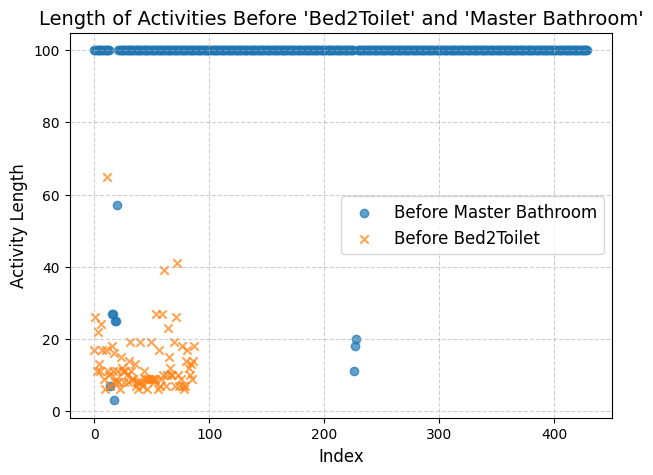

In [ ]:
import numpy as np
import pandas as pd

x = np.load(r'X.npy', allow_pickle=True)
# x = x.astype(float)
x[x < 0.2] = np.nan


activity1 = [i for i in range(np.size(y)) if y[i] == '1']
activity3 = [i for i in range(np.size(y)) if y[i] == '3']

print(len(activity1))
print(len(activity3))

# not_nan_counts_morning = [np.sum(~np.isnan(x[activity1[i] - 1])) for i in range(min(430, len(activity1)))]
# not_nan_counts_eve = [np.sum(~np.isnan(x[activity3[i] - 1])) for i in range(min(430, len(activity3)))]
not_nan_counts_morning = [np.sum(~np.isnan(x[activity1[i]])) for i in range(min(430, len(activity1)))]
not_nan_counts_eve = [np.sum(~np.isnan(x[activity3[i]])) for i in range(min(430, len(activity3)))]


# Create scatter plot to intuitively represent the lengths
plt.figure(figsize=(7, 5))
plt.scatter(range(len(not_nan_counts_eve)), not_nan_counts_eve, label="Before Master Bathroom", alpha=0.7, marker='o')
plt.scatter(range(len(not_nan_counts_morning)), not_nan_counts_morning, label="Before Bed2Toilet", alpha=0.7, marker='x')
# plt.scatter(range(len(not_nan_counts_kitchen)), not_nan_counts_dning, label="Before Kitchen", alpha=0.7, marker='v', color='b')

plt.title("Length of Activities Before 'Bed2Toilet' and 'Master Bathroom'", fontsize=14)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Activity Length", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig('bed_master.pdf')
plt.show()

In [23]:
result = []
enter_count = 0
leave_count = 0

for i in range(len(activity1)):
    not_nan_count_leave = np.sum(~np.isnan(x[activity1[i]-1]))
    leave = np.sum(~np.isnan(x[activity1[i]]))
    # print(not_nan_count_leave)
    result.append({'St-1':'other', 'Lt-1':not_nan_count_leave, 'St':'Bed2Toilet'})
    leave_count += 1

for i in range(len(activity3)):
    not_nan_count_enter = np.sum(~np.isnan(x[activity3[i]-1]))
    enter = np.sum(~np.isnan(x[activity3[i]]))
    # print(not_nan_count_enter)
    result.append({'St-1':'other', 'Lt-1':not_nan_count_enter, 'St':'Master Bathroom'})
    enter_count += 1

df = pd.DataFrame(result)
df['St'] = df['St'].replace({'Bed2Toilet': 0, 'Master Bathroom': 1})
L_mean = df['Lt-1'].sum()/(len(activity1) + len(activity3))
print(L_mean)
P_mean = 0.5

# each value minus the mean
df['Lt-1 - L_mean'] = df['Lt-1'] - L_mean
df['St - P_mean'] = df['St'] - P_mean
df['product'] = df['Lt-1 - L_mean'] * df['St - P_mean']
df['square'] = df['Lt-1 - L_mean']**2
alpha = df['product'].sum()/df['square'].sum()
print(alpha)
beta = P_mean - alpha * L_mean
print(beta)

93.09746161078031
0.002313552485984556
0.2846141362515274


/var/folders/p7/20f7xrt504ncpy6nhf4tjw480000gn/T/ipykernel_6253/3050156524.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['St'] = df['St'].replace({'Bed2Toilet': 0, 'Master Bathroom': 1})


In [24]:
df['P_bed2toilet'] = alpha * df['Lt-1'] + beta
# print(df['P_enter_home'])

# Ensure probabilities are within [0, 1]
df['P_bed2toilet'] = df['P_bed2toilet'].clip(0, 1)
# print(df['P_enter_home'])

# Predict 'enter home' if probability > 0.5, else 'leave home'
df['Predicted_St'] = (df['P_bed2toilet'] > 0.5).astype(int)
print(df['Predicted_St'])
print(df['St'])
# Evaluate the model
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

accuracy = accuracy_score(df['St'], df['Predicted_St'])
conf_matrix = confusion_matrix(df['St'], df['Predicted_St'])
f1 = f1_score(df['St'], df['Predicted_St'], average='binary')

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print(f"F1-Score: {f1:.2f}")

0       0
1       0
2       1
3       0
4       0
       ..
3186    1
3187    1
3188    1
3189    1
3190    1
Name: Predicted_St, Length: 3191, dtype: int64
0       0
1       0
2       0
3       0
4       0
       ..
3186    1
3187    1
3188    1
3189    1
3190    1
Name: St, Length: 3191, dtype: int64
Accuracy: 91.79%
Confusion Matrix:
[[  67   21]
 [ 241 2862]]
F1-Score: 0.96


In [11]:
x = np.load(r'X.npy', allow_pickle=True)
# x = x.astype(float)
x[x < 0.2] = np.nan


activity1 = [i for i in range(np.size(y)) if y[i] == '1']
activity3 = [i for i in range(np.size(y)) if y[i] == '3']

# 3 is master bathroom

In [17]:
result = []
enter_count = 0
leave_count = 0

for i in range(len(activity3)):
    not_nan_count_master = np.sum(~np.isnan(x[activity3[i]-1]))
    leave = np.sum(~np.isnan(x[activity3[i]]))
    
    result.append({'St-1':'other', 'Lt-1':not_nan_count_master, 'St':'master bathroom'})
    leave_count += 1

for i in range(len(activity1)):
    not_nan_count_bed = np.sum(~np.isnan(x[activity1[i]-1]))
    enter = np.sum(~np.isnan(x[activity1[i]]))
    
    result.append({'St-1':'other', 'Lt-1':not_nan_count_bed, 'St':'bed2toilet'})
    enter_count += 1

df = pd.DataFrame(result)
df['St'] = df['St'].replace({'bed2toilet': 0, 'master bathroom': 1})
df

/var/folders/p7/20f7xrt504ncpy6nhf4tjw480000gn/T/ipykernel_6253/3568789528.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['St'] = df['St'].replace({'bed2toilet': 0, 'master bathroom': 1})


,St-1,Lt-1,St
0,other,99,1
1,other,100,1
2,other,100,1
3,other,100,1
4,other,100,1
...,...,...,...
3186,other,76,0
3187,other,1,0
3188,other,1,0
3189,other,42,0


In [19]:
from sklearn.linear_model import LogisticRegression

L_mean = df['Lt-1'].sum()/(len(activity1) + len(activity3))
print(L_mean)
L_centered = df['Lt-1'] - L_mean

model = LogisticRegression(fit_intercept=True)
model.fit(L_centered.values.reshape(-1, 1), df['St'])

alpha = model.coef_[0][0]
beta = model.intercept_[0]

print(f"alpha = {alpha:.5f}, beta = {beta:.5f}")

93.09746161078031
alpha = 0.03507, beta = 4.11385
